### Importing all libraries and packages

In [1]:
#--- setup and import
import os, sys
import numpy as np
import pandas as pd
from importlib import reload
from datetime import time
import matplotlib.pyplot as plt
from importlib import reload

sys.path.insert(0, os.path.abspath(".."))

root = os.path.abspath("..")  # because your notebook is in /notebooks
if root not in sys.path:
    sys.path.append(root)

import src.feature_time as FT
import src.feature_volatility as FVOL
import src.feature_levels as FLEV

reload(FT)
reload(FVOL)
reload(FLEV)






<module 'src.feature_levels' from 'c:\\Users\\user\\Forex_prediction\\src\\feature_levels.py'>

### Read file and import tz-aware time features related to FX market

In [2]:
# --- Config ---
CSV_PATH = "../data/clean/EUR_USD_COMBINED_2021-2025_4years.csv"   
TS_COL   = "Gmt time"                              #
USE_CYCLICAL = False                               # Importing date related data in cyclical format for better NN performance 
SAVE_FEATHER = "../data/clean/minutes_features_pdf.feather"


In [3]:
# Loading the file
# Currently data consists of 4 years of minute data for EUR/USD
# and has GMT time OHLC and Volume columns
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
df.head(3)


Loaded: (1486245, 6)


,Gmt time,Open,High,Low,Close,Volume
0,2021-08-16 00:00:00,1.17939,1.17957,1.17937,1.17957,52.95
1,2021-08-16 00:01:00,1.17958,1.17963,1.17953,1.17953,14.39
2,2021-08-16 00:02:00,1.17954,1.17954,1.17944,1.17944,17.46


In [4]:
df = pd.read_csv(CSV_PATH, parse_dates=["Gmt time"])

# force Volume to be numeric (coerce errors into NaN)
df["Volume"] = pd.to_numeric(df["Volume"], errors="coerce")

# now drop NA/zero Volume
before = len(df)
df = df.dropna(subset=["Volume"])
df = df[df["Volume"] > 0]
after = len(df)
### current version of data has no NA/zero Volume rows , removed while concatinating files
print(f"Dropped {before - after} rows ({100*(before-after)/before:.2f}%) due to NA/zero Volume")

# sanity check
print("Unique Volume values (sample):", df["Volume"].unique()[:20])


Dropped 0 rows (0.00%) due to NA/zero Volume
Unique Volume values (sample): [52.95 14.39 17.46 16.03 12.33 28.38 32.48 28.08  9.   14.38 13.38 22.08
 26.02 16.37 16.7  81.06 49.89 19.25 17.33 22.85]


In [5]:
df = FT.add_ny_session_markers(
    df,
    dt_col="Gmt time",
    market_open_local="09:30",### explicitly defining market open and close time for NY
    market_close_local="16:00",
    warmup_minutes=30,
    roll_weekends=True,   # <- important
)


In [6]:
def _to_utc(series: pd.Series) -> pd.Series:
    s = pd.to_datetime(series, utc=False, errors="coerce")
    # if tz-naive, assume it's already UTC; if tz-aware (e.g., America/New_York), convert to UTC
    if getattr(s.dt, "tz", None) is None:
        return s.dt.tz_localize("UTC")
    return s.dt.tz_convert("UTC")


### Normalizing session markers

Ensures session markers are present in UTC:
Creates `dt_utc` if missing.  
Converts NY-local open/close/warmup → UTC.
Guarantees columns: `ny_open_utc`, `ny_warmup_end_utc`, `ny_close_utc`, `date_us_open`.

In [7]:
def normalize_session_markers(df_in: pd.DataFrame, dt_col: str = TS_COL, warmup_minutes: int = 30) -> pd.DataFrame:
    d = df_in.copy()
    # Ensure dt_utc
    if "dt_utc" not in d.columns:
        d["dt_utc"] = pd.to_datetime(d[dt_col], utc=True)
    # Build UTC markers from NY-local if missing
    if "ny_open_utc" not in d.columns:
        if "ny_open_ny" in d.columns:
            d["ny_open_utc"] = _to_utc(d["ny_open_ny"])
    if "ny_close_utc" not in d.columns:
        if "ny_close_ny" in d.columns:
            d["ny_close_utc"] = _to_utc(d["ny_close_ny"])
    if "ny_warmup_end_utc" not in d.columns:
        if "ny_warmup_end_ny" in d.columns:
            d["ny_warmup_end_utc"] = _to_utc(d["ny_warmup_end_ny"])
        elif "ny_open_utc" in d.columns:
            d["ny_warmup_end_utc"] = d["ny_open_utc"] + pd.Timedelta(minutes=warmup_minutes)
    # Final sanity: we must have these
    needed = ["ny_open_utc","ny_warmup_end_utc","ny_close_utc","date_us_open"]
    missing = [c for c in needed if c not in d.columns]
    if missing:
        raise KeyError(f"Missing session markers after normalization: {missing}")
    return d

df = normalize_session_markers(df, dt_col=TS_COL, warmup_minutes=30)

### Volatility flag via ATR
Classifies each US day as volatile or not using ATR

In [8]:
# stricter or looser binary flag:
df = FVOL.attach_volatility_score(
    df,
    dt_col="Gmt time",
    atr_lookback=14,
    atr_method="sma",   # or "ema"
    k_atr=1.4,         # raise for stricter (fewer volatile days)
    cap_lo=0.7, cap_hi=1.3
)

# sanity: share of volatile days
pct = df.drop_duplicates("date_us_open")["is_volatile"].mean() * 100
print(f"Volatile days ≈ {pct:.1f}% (k_atr={1.25})")

Volatile days ≈ 14.0% (k_atr=1.25)


In [9]:

reload(FLEV)

df = FLEV.compute_levels(
    df,
    ts_col="Gmt time",
    vwap_mode="rolling_24h",
    vwap_alpha=0.25,
    l1_use=True,
    ib_k=1.30,                # ← push L1 further out
    vol_score_col="vol_score",
    vol_scale_l1=True,
    vol_scale_fv=False,
    scale_mode="up_only",     # ← only widen, never shrink on quiet days
)


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_levels_styled(
    df: pd.DataFrame,
    start_date=None, end_date=None, ndays=3,
    tz: str = "UTC",
    show_updates: bool = True,
    show_price: bool = True,
):
    """
    Plot Close + ACTIVE levels with requested colors & FV gray fill.

    Colors:
      - FV boundaries: green
      - L1 (outer): purple
      - Midway (L1↔FV): blue
      - FV zone (FV_low..FV_high): light gray fill
      - FV mid & halves: green but faint (lower alpha)
    """

    # --- window selection by US trading day ---
    x = df.copy()
    x["dt_utc"] = pd.to_datetime(x["dt_utc"], utc=True)

    if start_date is not None:
        start_date = pd.to_datetime(start_date).date()
        if end_date is None:
            end_date = (pd.to_datetime(start_date) + pd.Timedelta(days=ndays-1)).date()
        else:
            end_date = pd.to_datetime(end_date).date()
        mask = (x["date_us_open"] >= start_date) & (x["date_us_open"] <= end_date)
        x = x.loc[mask]
        title_range = f"{start_date} → {end_date}"
    else:
        title_range = "full range"

    if x.empty:
        print("No data in selected window.")
        return

    # --- x-axis timezone ---
    xaxis = x["dt_utc"].dt.tz_convert("America/New_York") if tz == "America/New_York" else x["dt_utc"]

    # --- columns we need (ACTIVE variants so levels hold for the day) ---
    need = [
        "FV_low_adj_active","FV_mid_adj_active","FV_high_adj_active",
        "FV_half_dn_active","FV_half_up_active",
        "L1_dn_active","L1_mid_dn_active","L1_mid_up_active","L1_up_active",
    ]
    have = [c for c in need if c in x.columns]
    missing = [c for c in need if c not in x.columns]
    if len(have) < 3:
        raise ValueError(f"Missing active level columns: {missing}. Run compute_levels() first.")

    # --- plot ---
    fig, ax = plt.subplots(figsize=(14,6))

    # FV gray zone first (so everything else sits on top)
    if {"FV_low_adj_active","FV_high_adj_active"}.issubset(have):
        ax.fill_between(
            xaxis,
            x["FV_low_adj_active"],
            x["FV_high_adj_active"],
            color="gray", alpha=0.12, zorder=1, label="FV zone"
        )

    # Price
    if show_price and "Close" in x.columns:
        ax.plot(xaxis, x["Close"], color="black", lw=1.0, label="Close", zorder=3)

    # FV boundaries (green, solid)
    if "FV_low_adj_active" in have:
        ax.plot(xaxis, x["FV_low_adj_active"], color="green", lw=1.4, label="FV_low", zorder=4)
    if "FV_high_adj_active" in have:
        ax.plot(xaxis, x["FV_high_adj_active"], color="green", lw=1.4, label="FV_high", zorder=4)

    # FV mid & halves (fainter green)
    if "FV_mid_adj_active" in have:
        ax.plot(xaxis, x["FV_mid_adj_active"], color="green", alpha=0.35, lw=1.1, label="FV_mid", zorder=4)
    if "FV_half_dn_active" in have:
        ax.plot(xaxis, x["FV_half_dn_active"], color="green", alpha=0.25, lw=1.0, label="FV_half_dn", zorder=4)
    if "FV_half_up_active" in have:
        ax.plot(xaxis, x["FV_half_up_active"], color="green", alpha=0.25, lw=1.0, label="FV_half_up", zorder=4)

    # L1 outer (purple)
    if "L1_dn_active" in have:
        ax.plot(xaxis, x["L1_dn_active"], color="purple", lw=1.3, label="L1_dn", zorder=4)
    if "L1_up_active" in have:
        ax.plot(xaxis, x["L1_up_active"], color="purple", lw=1.3, label="L1_up", zorder=4)

    # Midway lines between L1 and FV (blue)
    if "L1_mid_dn_active" in have:
        ax.plot(xaxis, x["L1_mid_dn_active"], color="blue", lw=1.1, label="Mid_dn (L1↔FV)", zorder=4)
    if "L1_mid_up_active" in have:
        ax.plot(xaxis, x["L1_mid_up_active"], color="blue", lw=1.1, label="Mid_up (L1↔FV)", zorder=4)

    # Optional: vertical update markers at warmup end
    if show_updates and "ny_warmup_end_utc" in x.columns:
        ups = (x[["date_us_open","ny_warmup_end_utc"]]
               .drop_duplicates("date_us_open")
               .sort_values("date_us_open"))
        ups_x = ups["ny_warmup_end_utc"].dt.tz_convert("America/New_York") if tz=="America/New_York" else ups["ny_warmup_end_utc"]
        for t in ups_x:
            ax.axvline(t, color="gray", alpha=0.35, lw=0.8, linestyle="--", zorder=2)

    ax.set_title(f"Price + Levels ({title_range}, shown in {tz})")
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.25)

    # dedupe legend labels
    handles, labels = ax.get_legend_handles_labels()
    seen, h2, l2 = set(), [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l); h2.append(h); l2.append(l)
    ax.legend(h2, l2, loc="upper left", ncol=3, fontsize=8)

    plt.show()


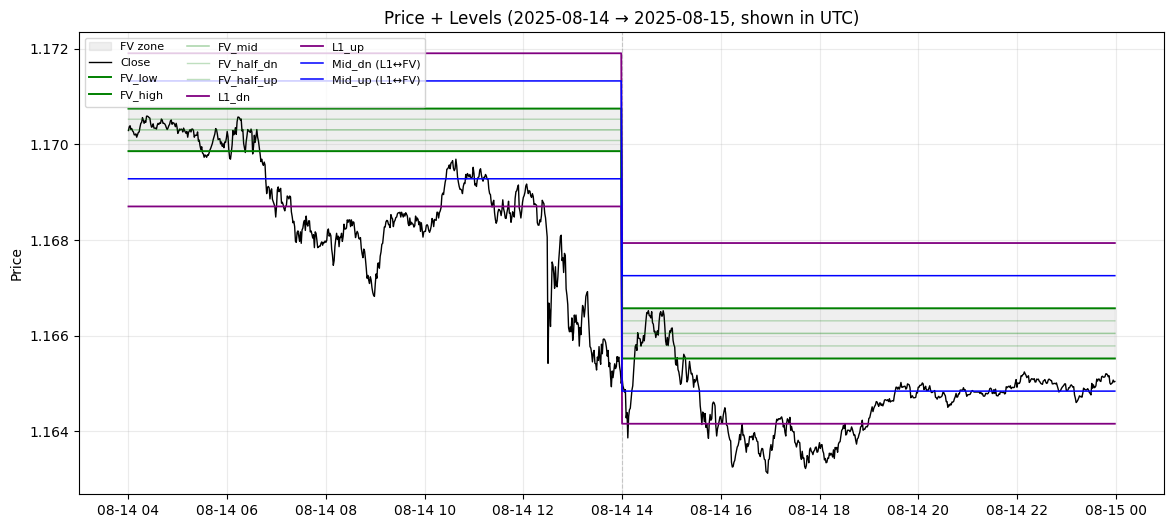

In [11]:
# 3 days starting Aug 21, 2021 (UTC x-axis)
plot_levels_styled(df, start_date="2025-08-14", ndays=2, tz="UTC")




### Backtest

### BAcktest 2

# MACHINE LEARNING MODEL